Overview
*** Write an overview of the case study that you are working on. (MINIMUM 200 words) ***
1. When it comes to questions and answers humans have a different way of
understanding and answering the question asked. In this case study we are going
to understand the same with the help of (Question-Answer) dataset from top
websites.
2. Humans have a unique way of answering any question asked. We first understand
the question, the intuition behind it, the significance of the question etc. With
machine it is different.
3. In this problem, we will help the machine understand these aspects of question
with the help of a question-answer dataset from different websites.
4. In our dataset we have 30 different aspects of question-answer like
‘question_conversational’, ‘question_body_critical’, ‘answer_helpful’ etc.
5. Our goal will be to find the scores for each of these aspects with the help of our
training dataset. In our training dataset we have scores associated with each of
these labels in the range of [0,1]. We will make our model learn these aspects and
try to evaluate the same for our test dataset.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras.backend as T
import gc
import os
from scipy.stats import spearmanr
from math import floor, ceil
import seaborn as sns

import tensorflow_hub as hub
np.set_printoptions(suppress=True)
tf.executing_eagerly()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


True

In [3]:
from google.colab import  drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
path='/content/gdrive/My Drive/case study2/' 

**Reading Our Datsets**

In [5]:
#train dataset
train_df=pd.read_csv(path+'train.csv')
train_df.head()

qa_id  ... answer_well_written
0      0  ...            1.000000
1      1  ...            0.888889
2      2  ...            0.888889
3      3  ...            1.000000
4      5  ...            1.000000

[5 rows x 41 columns]

In [6]:
#test data
test_df=pd.read_csv(path+'test.csv')
test_df.head()

qa_id  ...                           host
0     39  ...       gaming.stackexchange.com
1     46  ...    wordpress.stackexchange.com
2     70  ...       gaming.stackexchange.com
3    132  ...  raspberrypi.stackexchange.com
4    200  ...       travel.stackexchange.com

[5 rows x 11 columns]

In [7]:
#submission file
submission=pd.read_csv(path+'sample_submission.csv')
submission.head()

qa_id  ...  answer_well_written
0     39  ...              0.00308
1     46  ...              0.00448
2     70  ...              0.00673
3    132  ...              0.01401
4    200  ...              0.02074

[5 rows x 31 columns]

In [8]:
#columns in our train_data
train_columns=train_df.columns
test_columns=test_df.columns
print('-'*15+'Train Columns'+'-'*15)
print(train_columns)
print('-'*15+'Train data Shape'+'-'*15)
print(train_df.shape)
print('-'*15+'Test Columns'+'-'*15)
print(test_columns)
print('-'*15+'Test data Shape'+'-'*15)
print(test_df.shape)

---------------Train Columns---------------
Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible'

We thus have 6079 training points and 476 test points/ We have 41 train columns and 11 test columns. For the 30 columns we have to predict value for the test dataset. So, let us have a look at these 30 values

In [9]:
target_values=train_columns[11:]
print('Target columns are: ')
target_values

Target columns are: 


Index(['question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written'],
      dtype='object')

**Remove Punctuations & Decontracted Words**

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"couldn\'t", " could not", phrase)
    phrase = re.sub(r"couldnt", " could not", phrase)
    phrase = re.sub(r"didn\'t", " did not", phrase)
    phrase = re.sub(r"doesn\'t", " does not", phrase)
    phrase = re.sub(r"don\'t", " do not", phrase)
    phrase = re.sub(r"hadn\'t", " had not", phrase)
    phrase = re.sub(r"hasn\'t", " has not", phrase)
    phrase = re.sub(r"haven\'t", " have not", phrase)
    phrase = re.sub(r"he\'ll", " he will", phrase)
    phrase = re.sub(r"he\'d", " he would", phrase)
    phrase = re.sub(r"didn\'t", " did not", phrase)
    phrase = re.sub(r"wasn\'t", " was not", phrase)
    phrase = re.sub(r"you\'re", " you are", phrase)
    return phrase

In [11]:
#code reference: https://www.kaggle.com/codename007/start-from-here-quest-complete-eda-fe


def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()   
    text = " ".join(text)
    return(text)

In [12]:
#cleaning of train data
train_df['question_body']=train_df['question_body'].apply(clean_text)
train_df['question_body']=train_df['question_body'].apply(decontracted)
train_df['question_title']=train_df['question_title'].apply(clean_text)
train_df['question_title']=train_df['question_title'].apply(decontracted)
train_df['answer']=train_df['answer'].apply(clean_text)
train_df['answer']=train_df['answer'].apply(decontracted)

#cleaning of test data
test_df['question_body']=test_df['question_body'].apply(clean_text)
test_df['question_body']=test_df['question_body'].apply(decontracted)
test_df['question_title']=test_df['question_title'].apply(clean_text)
test_df['question_title']=test_df['question_title'].apply(decontracted)
test_df['answer']=test_df['answer'].apply(clean_text)
test_df['answer']=test_df['answer'].apply(decontracted)


#Training with Universal Sentece Encoder

Splitting our train data into train and test dataset for our validating our model

In [13]:
import random

random.seed(42)
valid_n_test_indexes=random.sample(list(range(1,len(train_df))),int(len(train_df)*0.3))
train_indexes = list(set(list(range(1,len(train_df))))-set(valid_n_test_indexes))
valid_indexes=random.sample(valid_n_test_indexes,int(len(train_df)*0.2))
test_indexes=list(set(valid_n_test_indexes)-set(valid_indexes))
                        

In [14]:
X_train=train_df.iloc[train_indexes]
X_valid=train_df.iloc[valid_indexes]
X_test=train_df.iloc[test_indexes]

print('Train data shape ='+str(X_train.shape))
print('Valid data shape ='+str(X_valid.shape))
print('Test data shape ='+str(X_test.shape))

Train data shape =(4255, 41)
Valid data shape =(1215, 41)
Test data shape =(608, 41)


In [15]:
train_title = X_train['question_title'].values.tolist()
train_question = X_train['question_body'].values.tolist()
train_answer = X_train['answer'].values.tolist()

valid_title = X_valid['question_title'].values.tolist()
valid_question = X_valid['question_body'].values.tolist()
valid_answer = X_valid['answer'].values.tolist()

test_title = X_test['question_title'].values.tolist()
test_question = X_test['question_body'].values.tolist()
test_answer = X_test['answer'].values.tolist()

In [16]:
kaggle_test_title=test_df['question_title'].values.tolist()
kaggle_test_question=test_df['question_body'].values.tolist()
kaggle_test_answer=test_df['answer'].values.tolist()

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

#code reference:https://tfhub.dev/google/universal-sentence-encoder-large/4

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/4")
embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])["outputs"]

print(embeddings)
#embedded_text = embed(text_input)


tf.Tensor(
[[ 0.01305102  0.02235121 -0.03263282 ... -0.00565093 -0.04793036
  -0.11492764]
 [ 0.05833397 -0.08185012  0.06890937 ... -0.00923879 -0.08695346
  -0.01415745]], shape=(2, 512), dtype=float32)


To avoid run time error we will encode our sentences in chunks

In [18]:
train_title_embedding =embed(train_title[:20])['outputs']
train_question_embedding =embed(train_question[:20])['outputs']
train_answer_embedding = embed(train_answer[:20])['outputs']
valid_title_embedding =embed(valid_title[:20])['outputs']
valid_question_embedding =embed(valid_question[:20])['outputs']
valid_answer_embedding = embed(valid_answer[:20])['outputs']
test_title_embedding = embed(test_title[:20])['outputs']
test_question_embedding =embed(test_question[:20])['outputs']
test_answer_embedding = embed(test_answer[:20])['outputs']




In [19]:
#for kaggle test input

kaggle_test_title_embedding = embed(kaggle_test_title[:20])['outputs']
kaggle_test_question_embedding =embed(kaggle_test_question[:20])['outputs']
kaggle_test_answer_embedding = embed(kaggle_test_answer[:20])['outputs']

In [20]:
#for train title
for i in range(20,len(train_title),20):
    temp=embed(train_title[i:i+20])['outputs']
    train_title_embedding=np.vstack((train_title_embedding,temp))
    

In [21]:
#for train question
for i in range(20,len(train_question),20):
    temp=embed(train_question[i:i+20])['outputs']
    train_question_embedding=np.vstack((train_question_embedding,temp))
    

In [22]:
#for train answer
for i in range(20,len(train_answer),20):
    temp=embed(train_answer[i:i+20])['outputs']
    train_answer_embedding=np.vstack((train_answer_embedding,temp))


In [23]:
#for valid title
for i in range(20,len(valid_title),20):
    temp=embed(valid_title[i:i+20])['outputs']
    valid_title_embedding=np.vstack((valid_title_embedding,temp))
    

In [24]:
#for valid question
for i in range(20,len(valid_question),20):
    temp=embed(valid_question[i:i+20])['outputs']
    valid_question_embedding=np.vstack((valid_question_embedding,temp))

In [25]:
#for valid answer
for i in range(20,len(valid_answer),20):
    temp=embed(valid_answer[i:i+20])['outputs']
    valid_answer_embedding=np.vstack((valid_answer_embedding,temp))

In [26]:
#for test title
for i in range(20,len(test_title),20):
    temp=embed(test_title[i:i+20])['outputs']
    test_title_embedding=np.vstack((test_title_embedding,temp))

In [27]:
#for test question
for i in range(20,len(test_question),20):
    temp=embed(test_question[i:i+20])['outputs']
    test_question_embedding=np.vstack((test_question_embedding,temp))

In [28]:
#for test answer
for i in range(20,len(test_answer),20):
    temp=embed(test_answer[i:i+20])['outputs']
    test_answer_embedding=np.vstack((test_answer_embedding,temp))

In [29]:
#embedding for kaggle test dataset

#for test title
for i in range(20,len(kaggle_test_title),20):
    temp=embed(kaggle_test_title[i:i+20])['outputs']
    kaggle_test_title_embedding=np.vstack((kaggle_test_title_embedding,temp))
    
    
#for test question
for i in range(20,len(kaggle_test_question),20):
    temp=embed(kaggle_test_question[i:i+20])['outputs']
    kaggle_test_question_embedding=np.vstack((kaggle_test_question_embedding,temp))
    
#for test answer
for i in range(20,len(kaggle_test_answer),20):
    temp=embed(kaggle_test_answer[i:i+20])['outputs']
    kaggle_test_answer_embedding=np.vstack((kaggle_test_answer_embedding,temp))



In [30]:
#shape of all the embeddings

print('Train Data Shape')
print(train_title_embedding.shape)
print(train_question_embedding.shape)
print(train_answer_embedding.shape)
print('-'*50)

print('Valid Data Shape')
print(valid_title_embedding.shape)
print(valid_question_embedding.shape)
print(valid_answer_embedding.shape)
print('-'*50)

print('Test Data Shape')
print(test_title_embedding.shape)
print(test_question_embedding.shape)
print(test_answer_embedding.shape)
print('-'*50)


print('Kaggle Test Data Shape')
print(kaggle_test_title_embedding.shape)
print(kaggle_test_question_embedding.shape)
print(kaggle_test_answer_embedding.shape)
print('-'*50)


Train Data Shape
(4255, 512)
(4255, 512)
(4255, 512)
--------------------------------------------------
Valid Data Shape
(1215, 512)
(1215, 512)
(1215, 512)
--------------------------------------------------
Test Data Shape
(608, 512)
(608, 512)
(608, 512)
--------------------------------------------------
Kaggle Test Data Shape
(476, 512)
(476, 512)
(476, 512)
--------------------------------------------------


In [31]:
import tensorflow.keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import Model


In [32]:
tf.keras.backend.clear_session()

In [33]:
#building out network

input_text1 = Input(shape=(512,))
input_text2 = Input(shape=(512,))
input_text3 = Input(shape=(512,))

x = Concatenate()([input_text1,input_text2,input_text3])

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(30,activation='sigmoid',name='output')(x)

model = Model(inputs=[input_text1,input_text2,input_text3], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1536)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [34]:
inputs_train=[train_title_embedding,train_question_embedding,train_answer_embedding]
inputs_valid=[valid_title_embedding,valid_question_embedding,valid_answer_embedding]
inputs_test=[test_title_embedding,test_question_embedding,test_answer_embedding]
kaggle_input_test=[kaggle_test_title_embedding,kaggle_test_question_embedding,kaggle_test_answer_embedding]
train_output=np.array(X_train[target_values])
valid_output=np.array(X_valid[target_values])
test_output=np.array(X_test[target_values])


In [35]:
import tensorflow.keras.backend as T
from keras.callbacks import Callback
from scipy.stats import spearmanr

def compute_spearmanr(trues, preds):
    rhos = []
 
    for col_trues, col_pred in zip(trues.T, preds.T):
     
        rhos.append(
            spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.mean(rhos)


class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_data, test_data, batch_size=16, fold=None):

        self.valid_inputs = valid_data[0]
        self.valid_outputs = valid_data[1]
        self.test_inputs = test_data
        
        self.batch_size = batch_size
        self.fold = fold
        
    def on_train_begin(self, logs={}):
        self.valid_predictions = []
        self.test_predictions = []
        
    def on_epoch_end(self, epoch, logs={}):
        print(len(self.valid_predictions))
        self.valid_predictions.append(
            self.model.predict(self.valid_inputs, batch_size=self.batch_size))
      
        rho_val = compute_spearmanr(
            self.valid_outputs, np.average(self.valid_predictions, axis=0))
        
        print("\nvalidation rho: %.4f" % rho_val)
        
        
        self.test_predictions.append(
            self.model.predict(self.test_inputs, batch_size=self.batch_size)
            
        
        )

Using TensorFlow backend.


In [36]:
import tensorflow.keras.backend as T
from keras.callbacks import Callback
from scipy.stats import spearmanr

custom_callback = CustomCallback(
        valid_data=(inputs_valid,valid_output), 
        test_data=inputs_test,
        batch_size=16,
        fold=None)


In [37]:
import datetime
import keras
%reload_ext tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

In [38]:
adam = tf.keras.optimizers.Adam()
#checkpoint,earlystop,
model.compile(loss=['mse'], optimizer=adam)

In [39]:
model.fit(inputs_train,train_output,batch_size=16,epochs =10,validation_data=(inputs_valid,valid_output),callbacks=[custom_callback,tensorboard_callback])

Epoch 1/10
258/266 [============================>.] - ETA: 0s - loss: 0.12710

validation rho: 0.2796
266/266 [==============================] - 2s 8ms/step - loss: 0.1254 - val_loss: 0.0763
Epoch 2/10
258/266 [============================>.] - ETA: 0s - loss: 0.05581

validation rho: 0.3089
266/266 [==============================] - 2s 7ms/step - loss: 0.0556 - val_loss: 0.0488
Epoch 3/10
261/266 [============================>.] - ETA: 0s - loss: 0.04752

validation rho: 0.3242
266/266 [==============================] - 2s 7ms/step - loss: 0.0475 - val_loss: 0.0456
Epoch 4/10
260/266 [============================>.] - ETA: 0s - loss: 0.04493

validation rho: 0.3298
266/266 [==============================] - 2s 7ms/step - loss: 0.0448 - val_loss: 0.0457
Epoch 5/10
259/266 [============================>.] - ETA: 0s - loss: 0.04254

validation rho: 0.3365
266/266 [==============================] - 2s 7ms/step - loss: 0.0424 - val_loss: 0.0457
Epoch 6/10
260/266 [=========================

#Now we check for our test data set

In [40]:
test_preds=model.predict(inputs_test)

In [41]:
spearman=compute_spearmanr(test_output, test_preds)

In [42]:
print('Spearman correlation on test dataset:  ',spearman)

Spearman correlation on test dataset:   0.3145401551221981


In [43]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

#Error Analysis

Now, we try out some error analysis so that we get to see the performance of our neural network more intutively.

Here we have 30 targets and for each target we have a value in the range of (0,1). Our metrics is spearman correlation and loss is mean_squared_error. We will start by calculating the mean_squared_error loss for each data point and see the same, and will do the same for metrics.

Here for error analysis purpose we will ue absolute distance loss as we have small values.

In [44]:
from sklearn.metrics import mean_squared_error

#we calcuate the train labels from our model
train_predcited_labels=model.predict(inputs_train)

#now we will calculate the loss for each of the target for every datapoint
all_loss={}
for j in range(len(target_values)):
  temp1=[]
  for i in range(train_predcited_labels.shape[0]):
    temp1.append(abs(train_output[i,j:j+1]-train_predcited_labels[i,j:j+1]))
  all_loss[target_values[j]]=temp1
  
 


Now we will have all the losses correspindng to each data point for every target in our dictionary  all_loss. So, let us visualize the losses with the help of pdfs and cdfs.

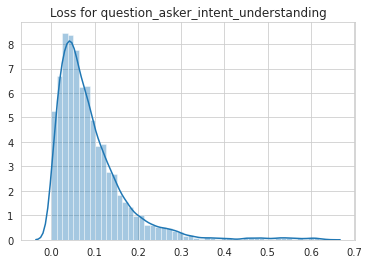

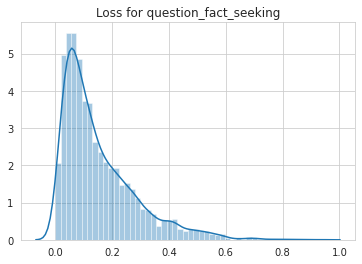

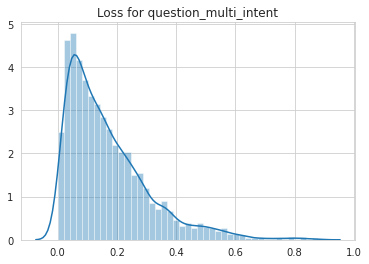

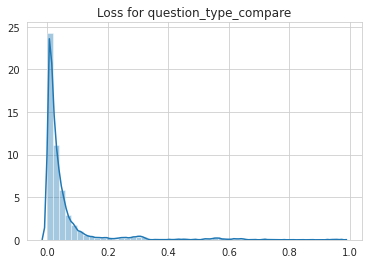

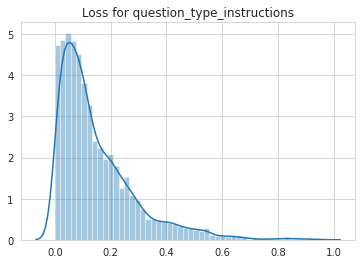

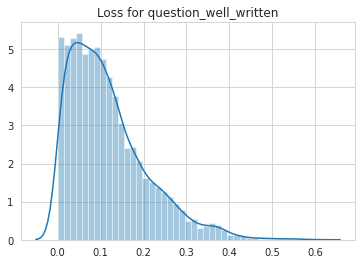

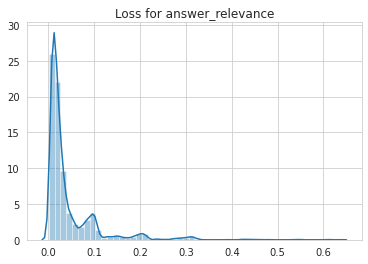

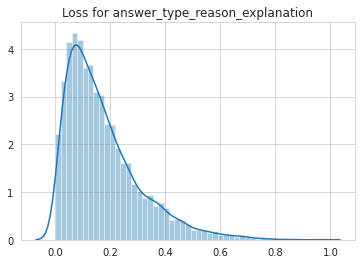

In [45]:
sns.set_style('whitegrid')
#code reference-->https://pythonbasics.org/seaborn_pairplot/ 
for i in range(0,len(target_values),4):  
   sns.distplot(all_loss[target_values[i]],label=target_values[i],kde=True)
   plt.title('Loss for '+target_values[i])     
   plt.show()

From the above plot we noticed that our loss range is mostly between 0.0 to 0.2 in most of the cases of which also most of the points lie between 0.0 and 0.1 only. So,  now we are going to analyze these data points with higher loss values and see if we can find a pettern in the same.

In [153]:
#now for each of the target_labels we will divide our loss into 5 different ranges and then
#find out our data points lying in each of them
loss_indices={}

for i in range(len(target_values)):
  loss=all_loss[target_values[i]]
  loss1=[]
  loss2=[]
  loss3=[]
  loss4=[]
  loss5=[]
  for j in range(len(loss)):
    if loss[j]<=0.02 and loss[j]>0:
      loss1.append(j)
    elif loss[j]>0.02 and loss[j] <=0.1:
      loss2.append(j)
    elif loss[j]>0.1 and loss[j]<=0.5:
      loss3.append(j)
    elif loss[j]>0.2 and loss[j] <=0.9:
      loss4.append(j)
    else:
      loss5.append(j)
  final_list=[loss1,loss2,loss3,loss4,loss4]
  #print(len(loss1)+len(loss2)+len(loss3)+len(loss4)+len(loss5))
  loss_indices[target_values[i]]=final_list



 

So, now as we have got all our data points, let us have a look at the maximum count of the same, and find out if there are any common data points with high loss values for all the thirty targets.

So let us first see the number of datapoints for each loss range

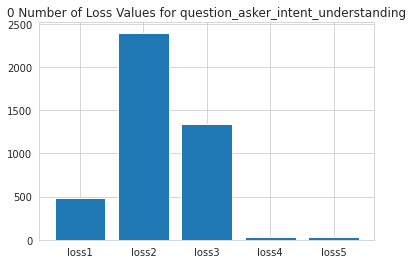

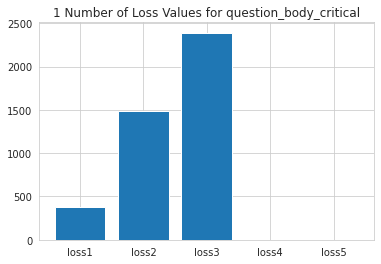

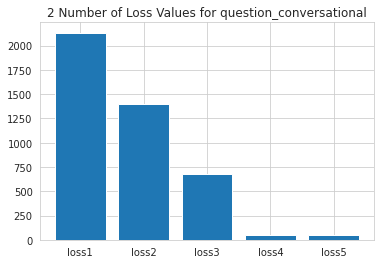

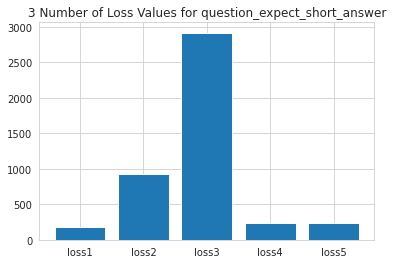

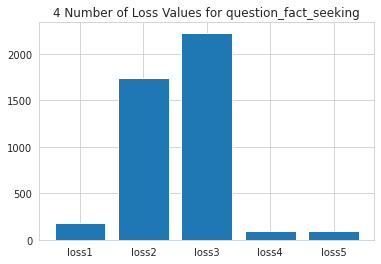

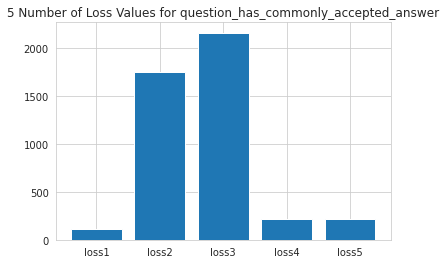

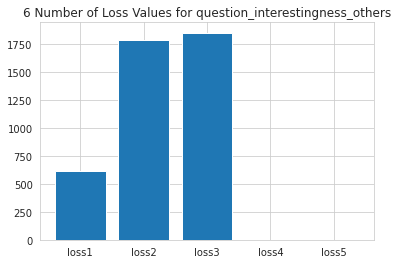

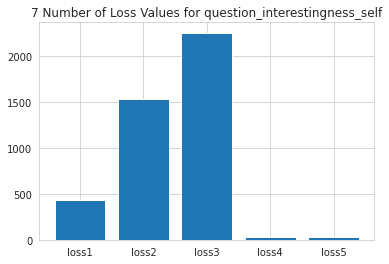

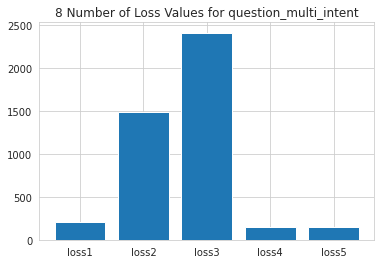

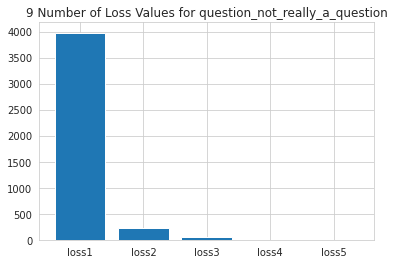

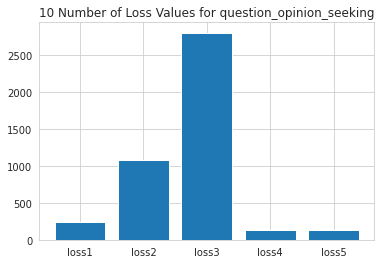

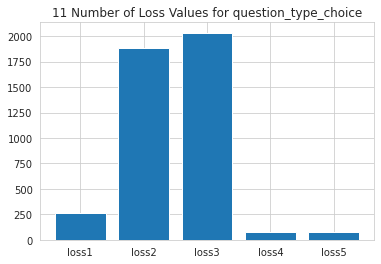

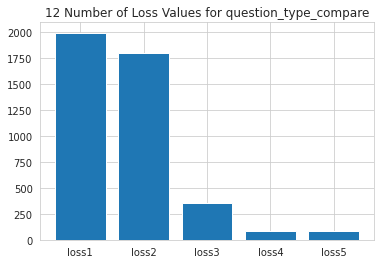

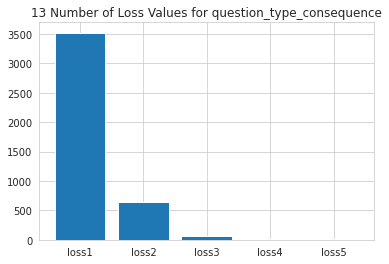

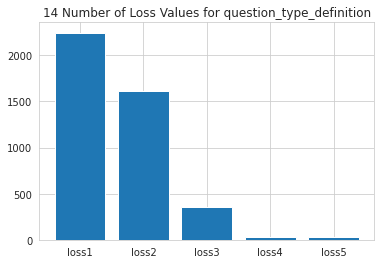

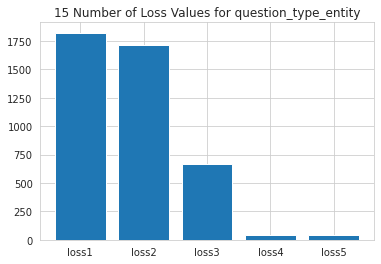

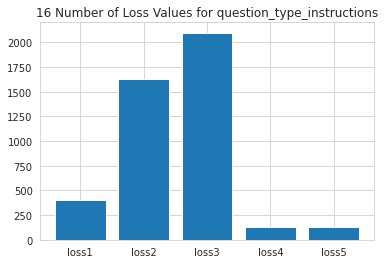

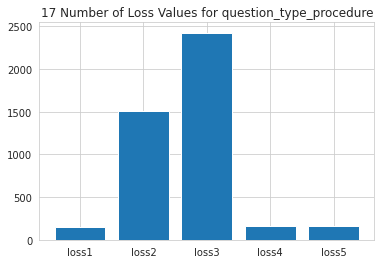

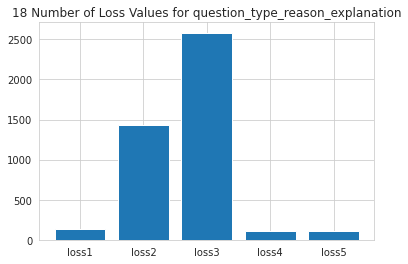

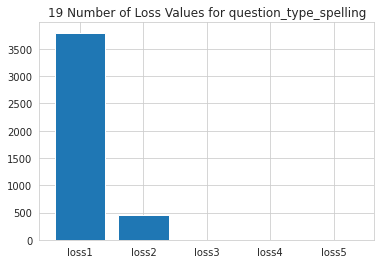

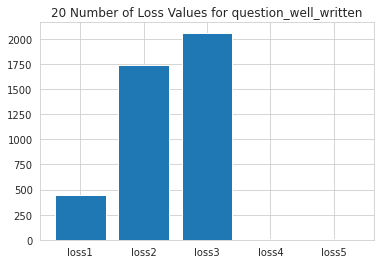

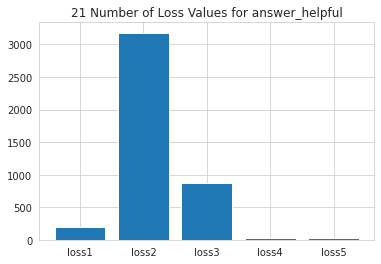

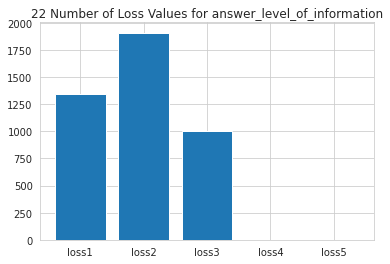

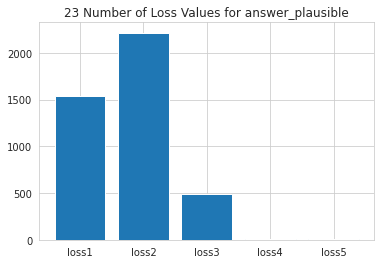

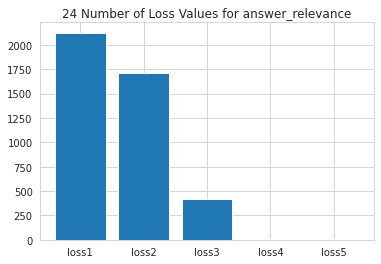

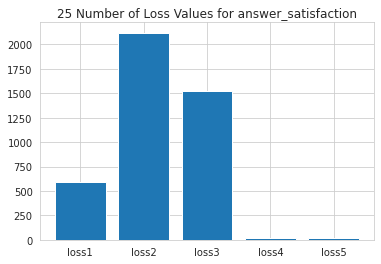

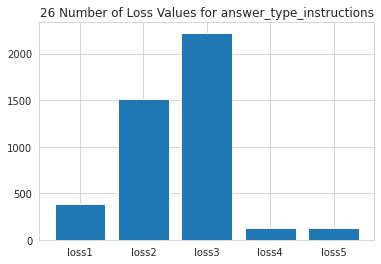

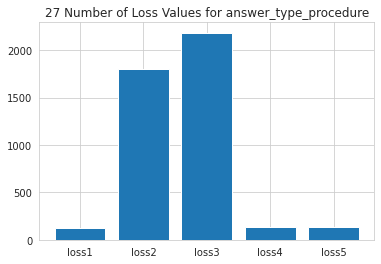

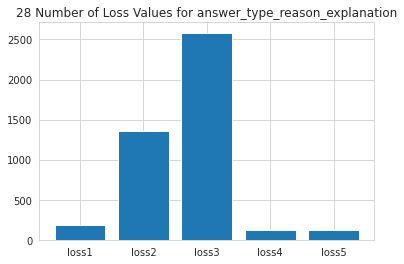

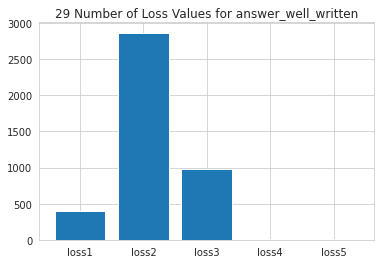

In [154]:
for i in range(len(target_values)):
  temp_array=np.array([len(ele) for ele in loss_indices[target_values[i]]])
  plt.bar(['loss1','loss2','loss3','loss4','loss5'],temp_array)
  plt.title(str(i)+' Number of Loss Values for '+target_values[i])
  plt.show()

#Observations

From the above plot we can see that most of the loss values lie in the range of (0to0.02) for all the 30 target variables. This loss value is pretty  low hence, we will analyze the datapoints which have a higher loss value.



In [155]:
#loss_indices[target_values[0]][4]

In [156]:
#First let us have a look at the points which belong to the loss_5 category that is with loss_value 0.4

loss5_indices=[]
for i in range(len(target_values)):
      loss5_indices.extend(loss_indices[target_values[i]][4])
loss5_indices=list(set(loss5_indices))
df_loss5=train_df.iloc[loss5_indices]
df_loss5.head()




qa_id  ... answer_well_written
1      1  ...            0.888889
2      2  ...            0.888889
3      3  ...            1.000000
4      5  ...            1.000000
5      6  ...            0.777778

[5 rows x 41 columns]

In [157]:
df_loss5.shape

(1420, 41)

We need to now find out if there exists any patterns in these datapoints. So, let us do a little EDA on this dataframe.

In [158]:
df_loss5.describe()

qa_id  ...  answer_well_written
count  1420.000000  ...          1420.000000
mean   3409.490141  ...             0.907746
std    1961.108587  ...             0.101990
min       1.000000  ...             0.333333
25%    1712.000000  ...             0.888889
50%    3450.500000  ...             0.888889
75%    5095.000000  ...             1.000000
max    6782.000000  ...             1.000000

[8 rows x 31 columns]

**Category Distrbution**

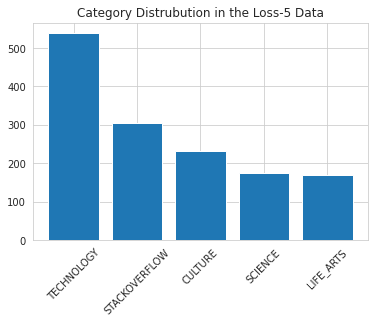

In [159]:
categ=df_loss5['category'].value_counts() 
plt.bar(categ.index,height=categ) 
plt.title('Category Distrubution in the Loss-5 Data')
plt.xticks(rotation=45)
plt.show()

**Host Distrbution**

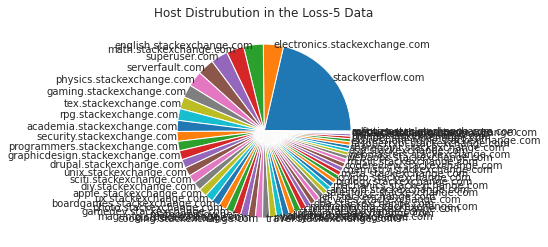

In [160]:
host=df_loss5['host'].value_counts()
plt.pie(host,labels=host.index,labeldistance=1) 
plt.title('Host Distrubution in the Loss-5 Data') 
plt.show()

Since these distrubutins are same as our training data we will go more granualar and see these distbrutions for each of the target values individually if these is a pattern

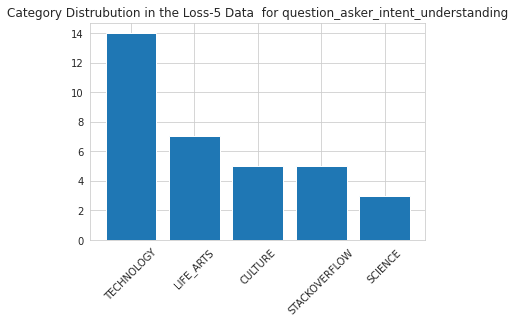

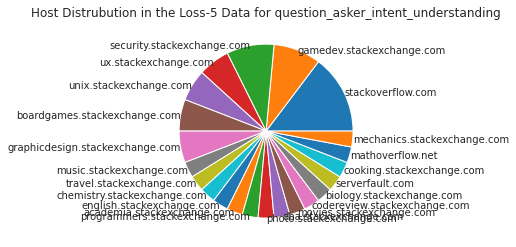

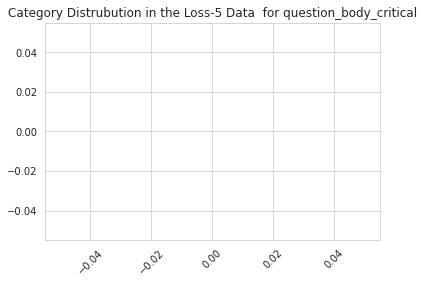

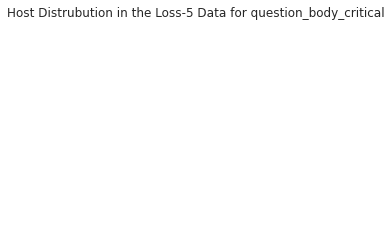

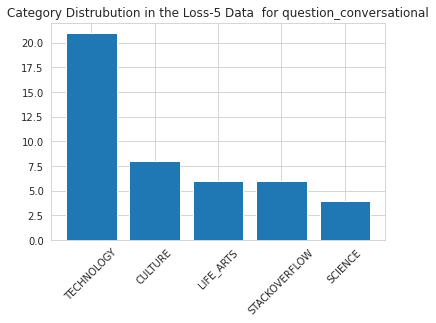

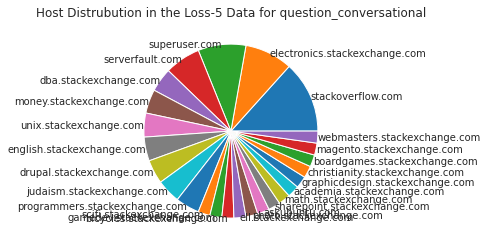

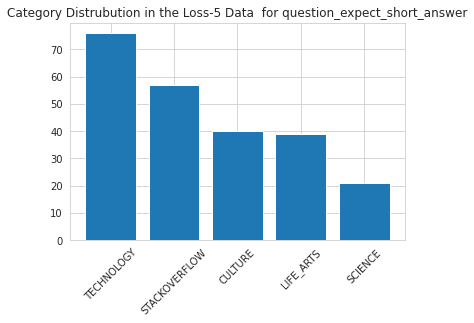

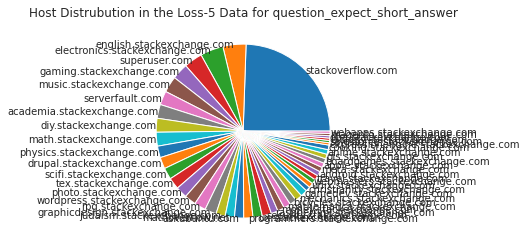

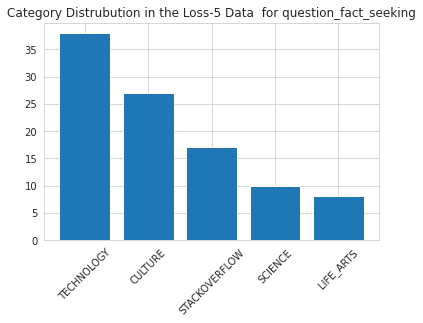

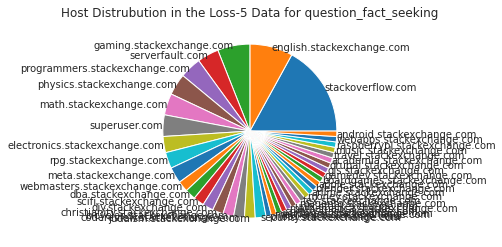

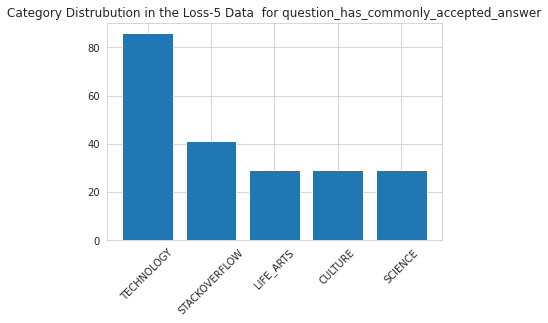

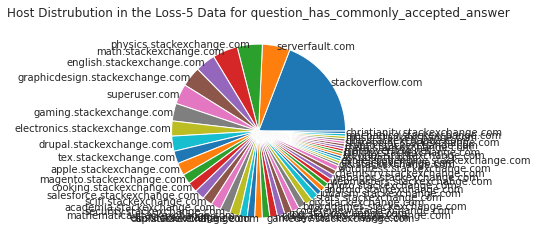

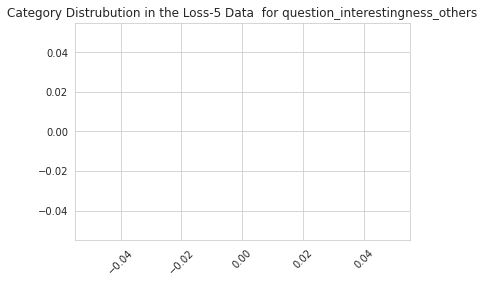

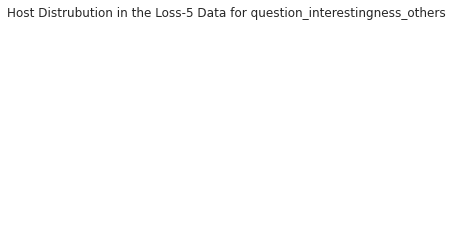

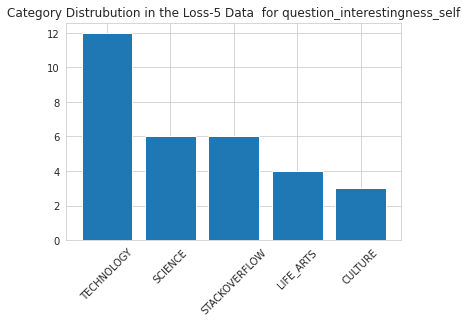

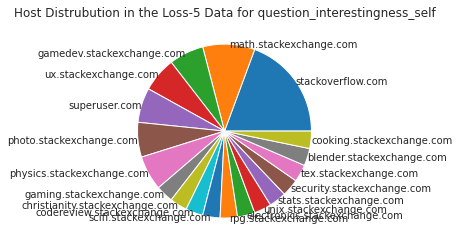

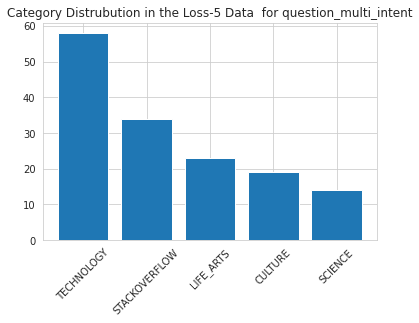

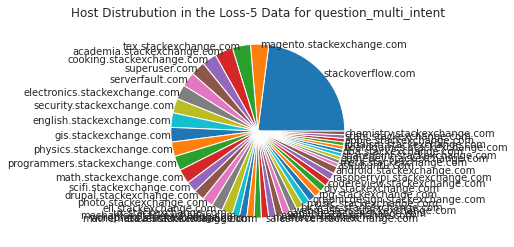

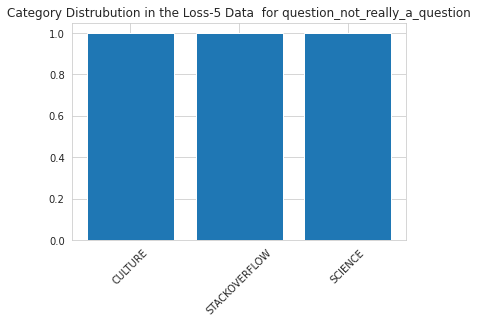

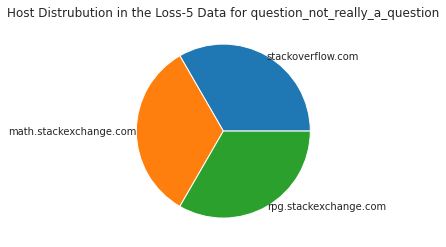

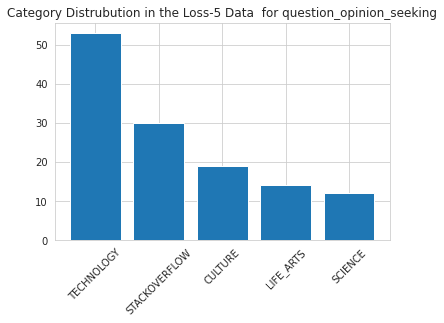

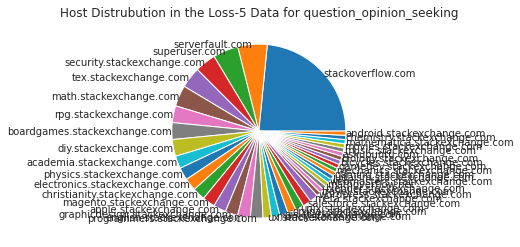

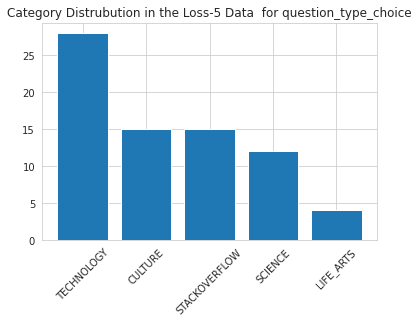

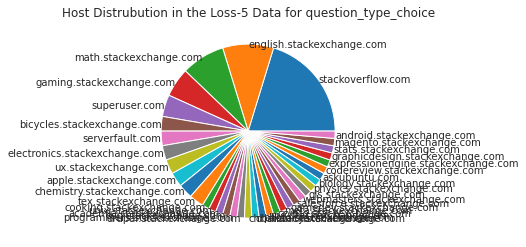

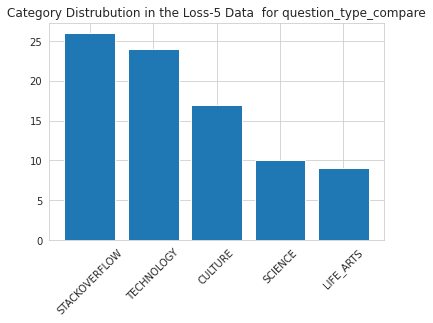

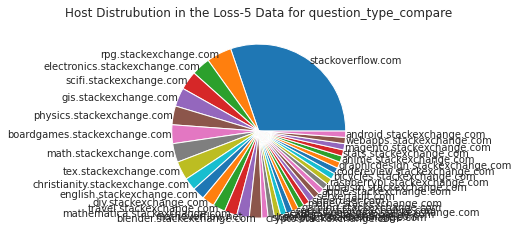

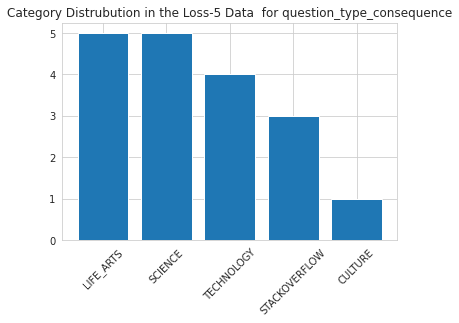

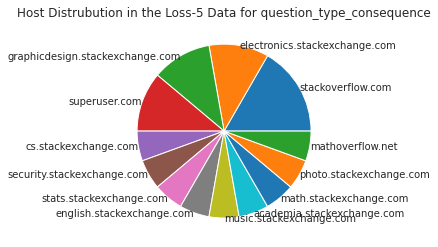

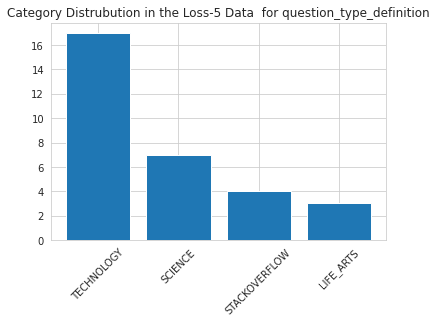

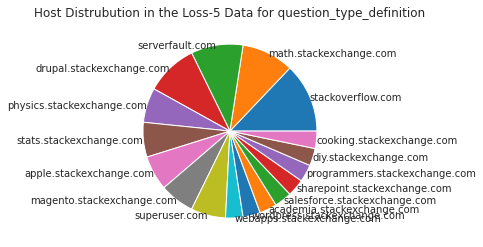

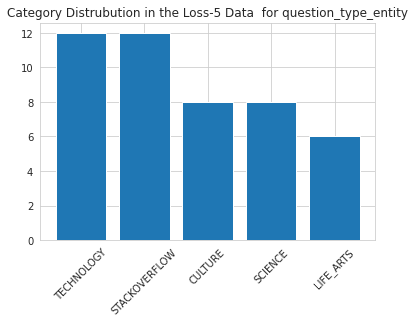

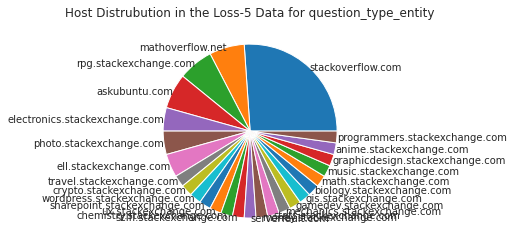

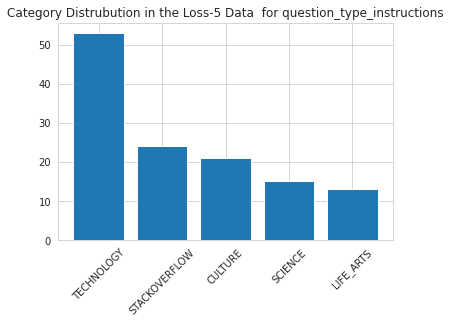

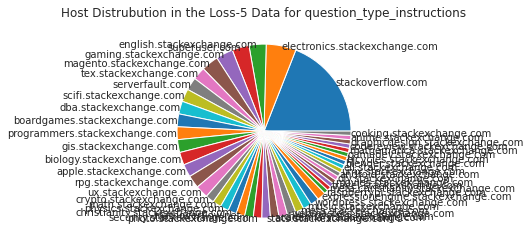

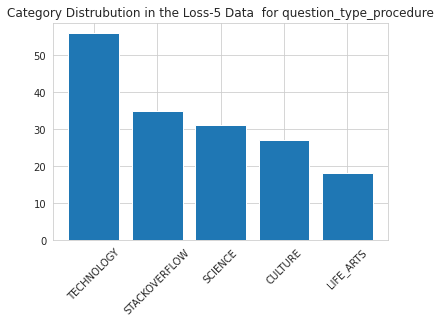

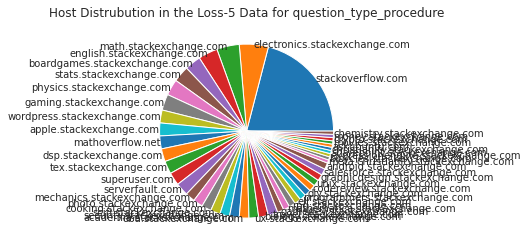

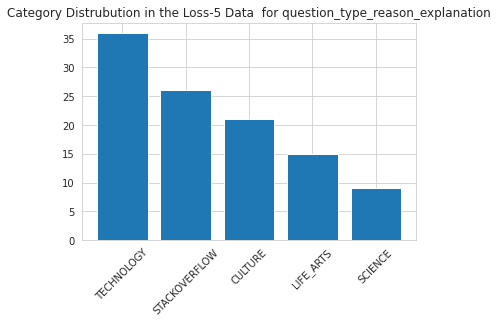

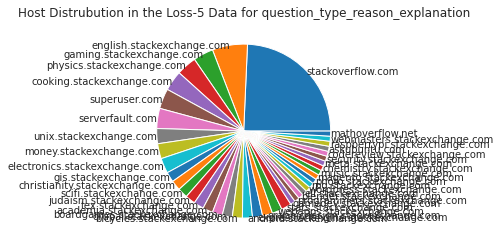

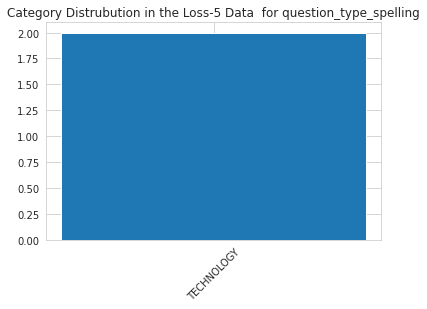

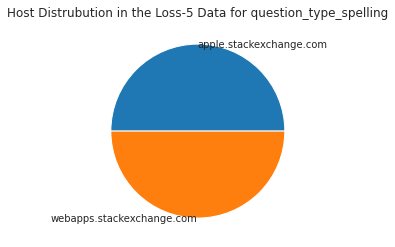

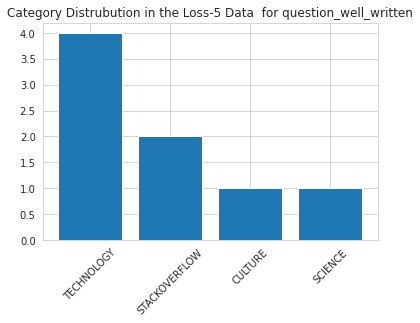

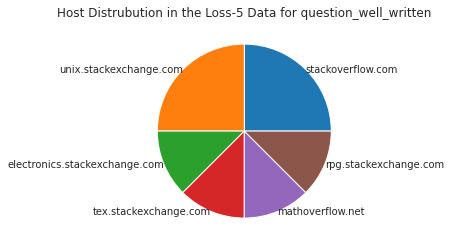

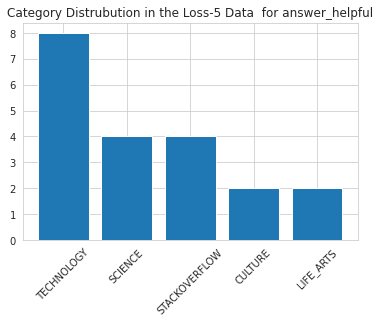

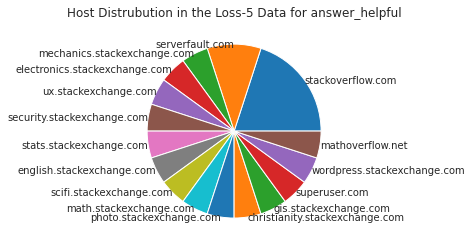

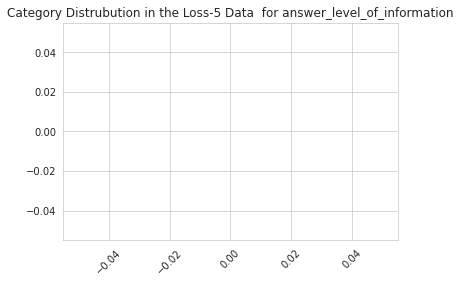

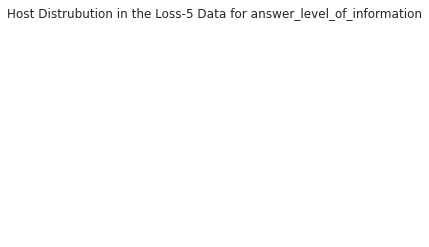

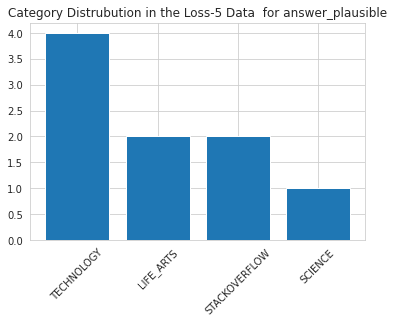

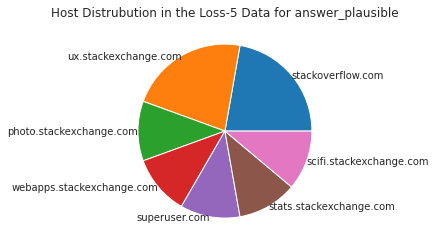

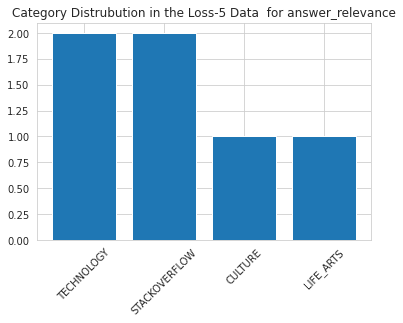

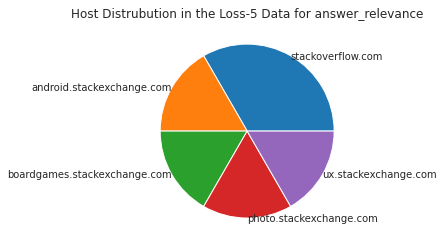

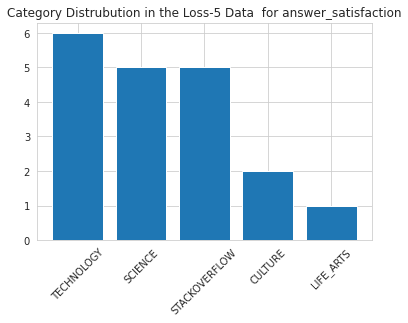

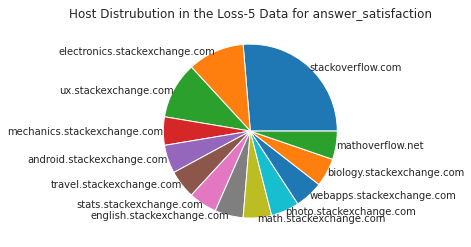

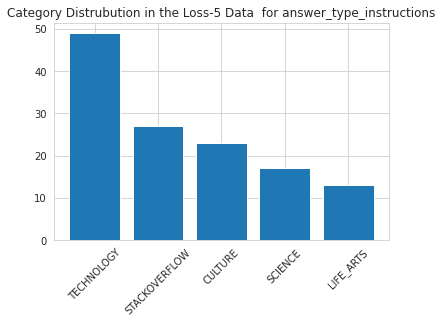

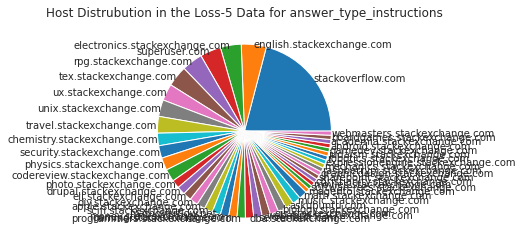

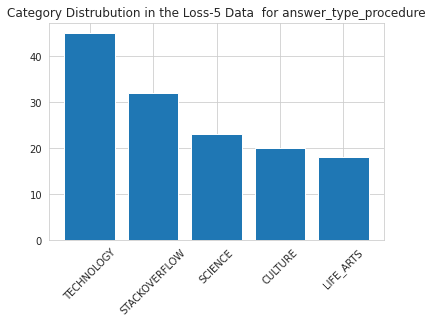

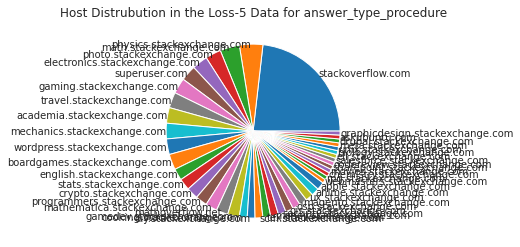

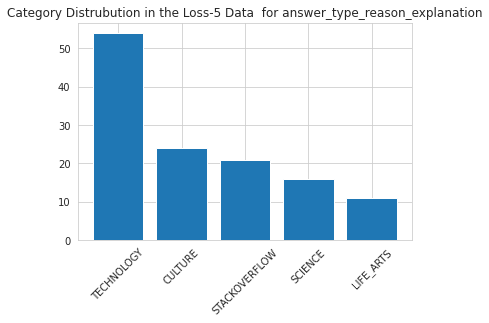

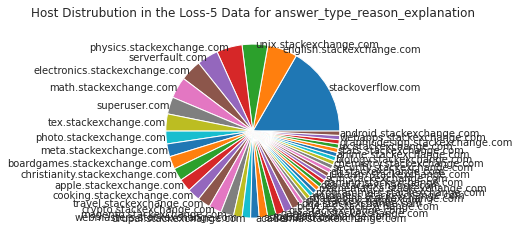

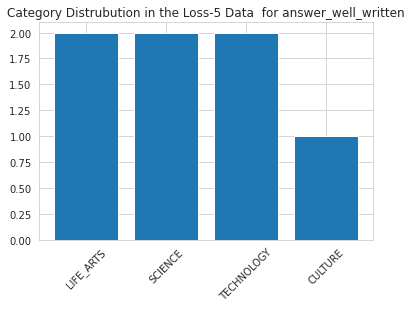

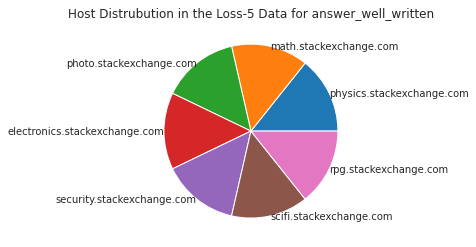

In [161]:
for i in range(len(target_values)):
      temp_ind = (loss_indices[target_values[i]][4])
      temp_df=train_df.iloc[temp_ind]
      categ=temp_df['category'].value_counts() 
      plt.bar(categ.index,height=categ) 
      plt.title('Category Distrubution in the Loss-5 Data  for '+target_values[i])
      plt.xticks(rotation=45)
      plt.show()
      host=temp_df['host'].value_counts()
      plt.pie(host,labels=host.index,labeldistance=1) 
      plt.title('Host Distrubution in the Loss-5 Data for '+target_values[i]) 
      plt.show()


From the above plots it is clear the the distrubution in these is almost the same as our original dataset. Hence, the problem is not with this pattern but with some pattern in the text representations.

Hence, we need to go more granular in it. For this purpose we will first have a look at the POS-tagging in our dataset and see if that has any patterns.

#Sentece_lenght

In [162]:
title_len=[len(ele) for ele in df_loss5['question_title']]
question_len=[len(ele) for ele in df_loss5['question_body']]
answer_len=[len(ele) for ele in df_loss5['answer']]

title_len_train=[len(ele) for ele in train_df['question_title']]
question_len_train=[len(ele) for ele in train_df['question_body']]
answer_len_train=[len(ele) for ele in train_df['answer']]

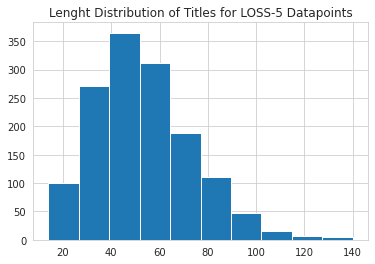

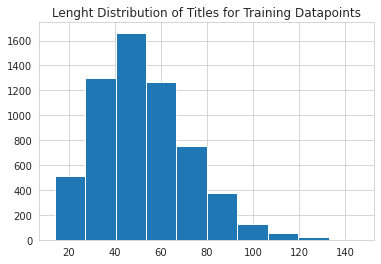

In [163]:
plt.hist(title_len)
plt.title('Lenght Distribution of Titles for LOSS-5 Datapoints')
plt.show()

plt.hist(title_len_train)
plt.title('Lenght Distribution of Titles for Training Datapoints')
plt.show()

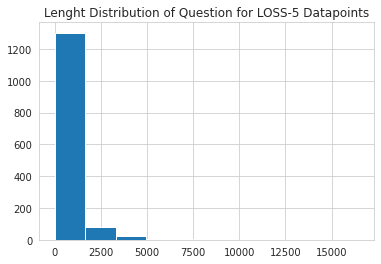

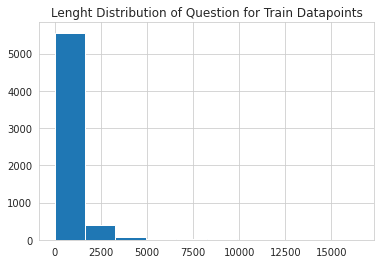

In [164]:
plt.hist(question_len)
plt.title('Lenght Distribution of Question for LOSS-5 Datapoints')
plt.show()

plt.hist(question_len_train)
plt.title('Lenght Distribution of Question for Train Datapoints')
plt.show()

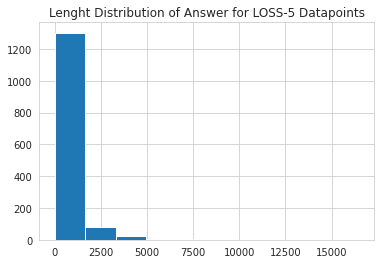

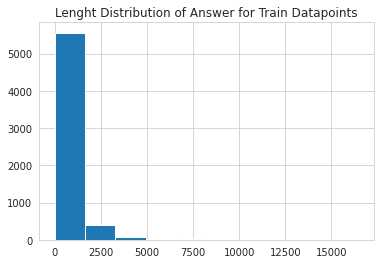

In [165]:
plt.hist(question_len)
plt.title('Lenght Distribution of Answer for LOSS-5 Datapoints')
plt.show()

plt.hist(question_len_train)
plt.title('Lenght Distribution of Answer for Train Datapoints')
plt.show()

#Observation:

The lenght distrubution for all the datapoints appear to be the same.

#Analaysis for Word Frequencies

Next we will check the word frequencies of for the dataset. We will check it separately for our three text features and let us see if we find any patterns in the same.

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

title_vect=CountVectorizer()
ques_vect=CountVectorizer()
ans_vect=CountVectorizer()

title_vocab=title_vect.fit_transform(train_title)
quest_vocab=ques_vect.fit_transform(train_question)
ans_vocab=ans_vect.fit_transform(train_answer)

**Let us first analyze the word frequencies taking help of a box plot**

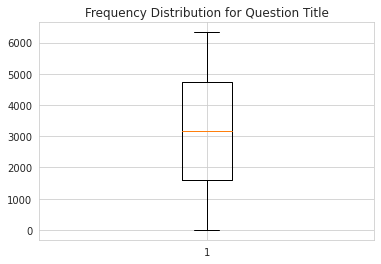

In [167]:
plt.boxplot(title_vect.vocabulary_.values())
plt.title('Frequency Distribution for Question Title')
plt.show()

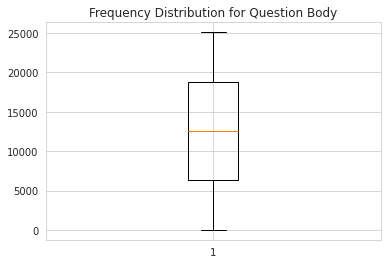

In [168]:
plt.boxplot(ques_vect.vocabulary_.values())
plt.title('Frequency Distribution for Question Body')
plt.show()

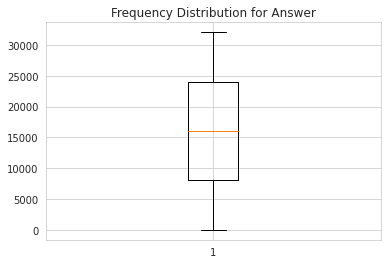

In [169]:
plt.boxplot(ans_vect.vocabulary_.values())
plt.title('Frequency Distribution for Answer')
plt.show()

**Observation from Plots**
From the above plots we can mke the following observations
1. For question title, the most frequent words occur more than 6000 times, also most of the word frequency count lies between 1500 to 4500.

2. For question body, the maximum frequency is 25000, whereas most of the word freuncy lie between 5200 ad 1800

3. For answer,the maximum frequency is 32000 and for most of the words it lies between 8000 and 24000.

Now, let us analyze and see whether the data points for which we are getting higher loss (loss5) in our cases, have the most frequent or the least frequent occuring words.

**For Question Title**

In [170]:
most_freq_words_ques=[]
least_freq_words_ques=[]

#getting the most frequent and least frequent words
for word in title_vect.vocabulary_.keys():
  if title_vect.vocabulary_[word] >=6000:
    most_freq_words_ques.append(word)
  if title_vect.vocabulary_[word] <=300:
    least_freq_words_ques.append(word)

#now let us see the the count of these words in our data_points with loss5
most_fre_count_question=[]
least_fre_count_question=[]
for sentence in tqdm(df_loss5['question_title']):
  count_m=0
  count_l=0
  for word in sentence.split():
    if word in most_freq_words_ques:
      count_m=count_m+1
    elif word in least_freq_words_ques:
      count_l=count_l+1
  most_fre_count_question.append(count_m)
  least_fre_count_question.append(count_l)
    


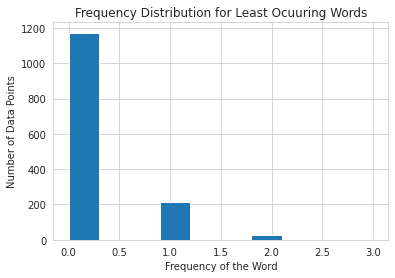

In [171]:
plt.hist(least_fre_count_question)
plt.title('Frequency Distribution for Least Ocuuring Words')
plt.xlabel('Frequency of the Word')
plt.ylabel('Number of Data Points')
plt.show()

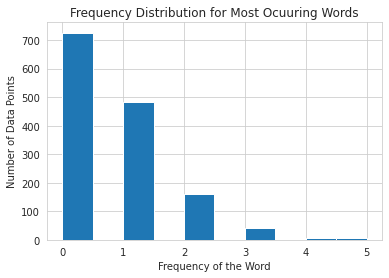

In [172]:
plt.hist(most_fre_count_question)
plt.title('Frequency Distribution for Most Ocuuring Words')
plt.xlabel('Frequency of the Word')
plt.ylabel('Number of Data Points')
plt.show()

**Observations**
From the above plot we can see that the most frequent_words does not occur as many times in these data points as the occur in others. This might be one of the reasons for higher loss in them. 

Now, let us do the same analysis for question_body and answer

**Question Body**

In [173]:
most_freq_words_body=[]
least_freq_words_body=[]

#getting the most frequent and least frequent words
for word in ques_vect.vocabulary_.keys():
  if ques_vect.vocabulary_[word] >=22000:
    most_freq_words_body.append(word)
  if ques_vect.vocabulary_[word] <=600:
    least_freq_words_body.append(word)

#now let us see the the count of these words in our data_points with loss5
most_fre_count_body=[]
least_fre_count_body=[]
for sentence in tqdm(df_loss5['question_body']):
  count_m=0
  count_l=0
  for word in sentence.split():
    if word in most_freq_words_body:
      count_m=count_m+1
    elif word in least_freq_words_body:
      count_l=count_l+1
  most_fre_count_body.append(count_m)
  least_fre_count_body.append(count_l)
    


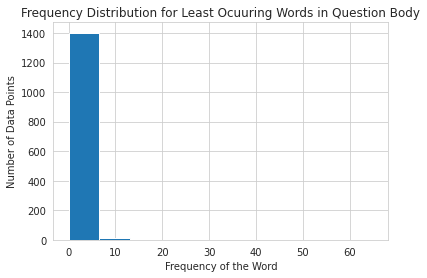

In [174]:
plt.hist(least_fre_count_body)
plt.title('Frequency Distribution for Least Ocuuring Words in Question Body')
plt.xlabel('Frequency of the Word')
plt.ylabel('Number of Data Points')
plt.show()

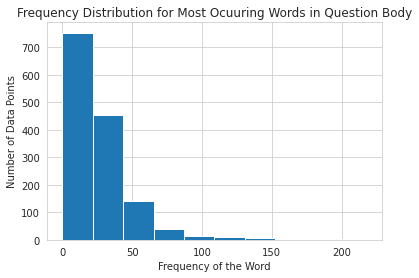

In [175]:
plt.hist(most_fre_count_body)
plt.title('Frequency Distribution for Most Ocuuring Words in Question Body')
plt.xlabel('Frequency of the Word')
plt.ylabel('Number of Data Points')
plt.show()

**Observation**
From the above plots we can see that even in the case of question_body
the frequency of the most occuring words is less for the loss_data pointd as compared to others.

**For Answer**

In [176]:
most_freq_words_ans=[]
least_freq_words_ans=[]

#getting the most frequent and least frequent words
for word in ans_vect.vocabulary_.keys():
  if ans_vect.vocabulary_[word] >=22000:
    most_freq_words_ans.append(word)
  if ans_vect.vocabulary_[word] <=600:
    least_freq_words_ans.append(word)

#now let us see the the count of these words in our data_points with loss5
most_fre_count_ans=[]
least_fre_count_ans=[]
for sentence in tqdm(df_loss5['answer']):
  count_m=0
  count_l=0
  for word in sentence.split():
    if word in most_freq_words_ans:
      count_m=count_m+1
    elif word in least_freq_words_ans:
      count_l=count_l+1
  most_fre_count_ans.append(count_m)
  least_fre_count_ans.append(count_l)
    

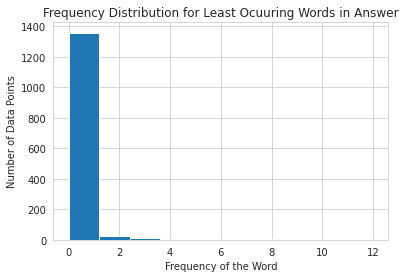

In [177]:
plt.hist(least_fre_count_ans)
plt.title('Frequency Distribution for Least Ocuuring Words in Answer')
plt.xlabel('Frequency of the Word')
plt.ylabel('Number of Data Points')
plt.show()

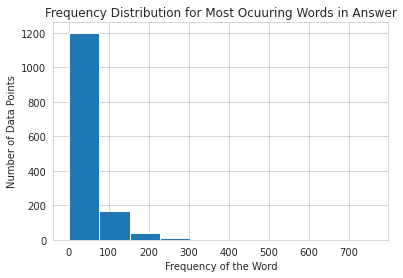

In [178]:
plt.hist(most_fre_count_ans)
plt.title('Frequency Distribution for Most Ocuuring Words in Answer')
plt.xlabel('Frequency of the Word')
plt.ylabel('Number of Data Points')
plt.show()

**Observations**
In case of answers also we observe the same data pattern of getting less number of most frequent words as compared to other data points. These words probably might be having some useful information that is counting towards improving the metrics which occurs less than usual.

#POS-Tagging for Error Analysis

One of the common reasons for high loss values in NLP is because of the names-entities that did not carry much information often. Let us see, if same is the case with our dataset

In [59]:
!pip install nltk

In [119]:
import nltk

In [120]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [121]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
stop_words = set(stopwords.words('english')) 
  

**Function for POS-Tagging Counting Nounns and Verbs**

In [179]:
def pos_tag(column):#code reference:https://www.geeksforgeeks.org/part-speech-tagging-stop-words-using-nltk-python/
  count_noun=[]
  count_verb=[]
  for sentence in tqdm(column):
    n=0
    v=0
    wordsList = nltk.word_tokenize(sentence) 
    wordsList = [w for w in wordsList if not w in stop_words]  # removing stop words from wordList 
    #  Using a Tagger. Which is part-of-speech  
    # tagger or POS-tagger.  
    tagged = nltk.pos_tag(wordsList)
    for ele in tagged:
      if ele[1]=='NN' or ele[1]=='NNS':
        n=n+1
      elif ele[1]=='VBG' or ele[1]=='VBP':
        v=v+1
    count_noun.append(n)
    count_verb.append(v)  
  return count_noun,count_verb

**For Question Title**

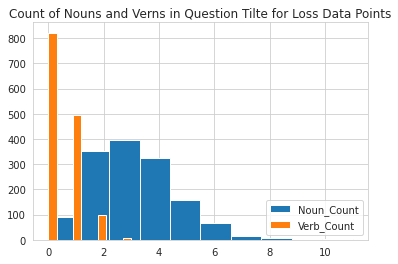

In [180]:
count_noun_title,count_verb_title=pos_tag(df_loss5['question_title'])
plt.hist(count_noun_title)
plt.hist(count_verb_title)
plt.title('Count of Nouns and Verns in Question Tilte for Loss Data Points')
plt.legend(["Noun_Count", "Verb_Count"], loc ="lower right") 
plt.show()

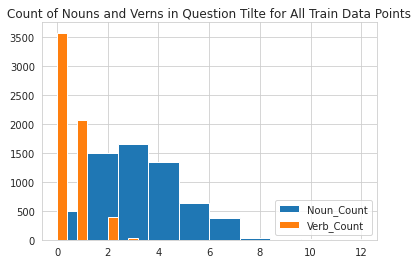

In [181]:
count_noun_title,count_verb_title=pos_tag(train_df['question_title'])
plt.hist(count_noun_title)
plt.hist(count_verb_title)
plt.title('Count of Nouns and Verns in Question Tilte for All Train Data Points')
plt.legend(["Noun_Count", "Verb_Count"], loc ="lower right") 
plt.show()

**Observation**

For question title the distribution for the number of nouns and verbs looks same for loss data points and train data points. Hence, it will be safe to say that this probably is not the reason higher loss value for these data points.

**For QUestion Body**

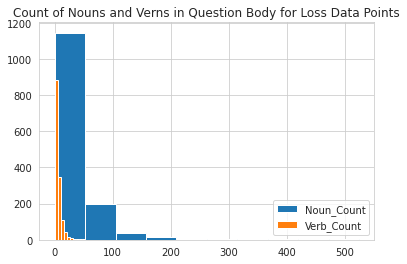

In [182]:
count_noun_title,count_verb_title=pos_tag(df_loss5['question_body'])
plt.hist(count_noun_title)
plt.hist(count_verb_title)
plt.title('Count of Nouns and Verns in Question Body for Loss Data Points')
plt.legend(["Noun_Count", "Verb_Count"], loc ="lower right") 
plt.show()

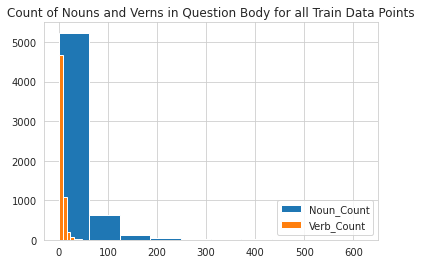

In [183]:
count_noun_title,count_verb_title=pos_tag(train_df['question_body'])
plt.hist(count_noun_title)
plt.hist(count_verb_title)
plt.title('Count of Nouns and Verns in Question Body for all Train Data Points')
plt.legend(["Noun_Count", "Verb_Count"], loc ="lower right") 
plt.show()

**Observation**

While checking for question_body from the above plot it seems that the distribution for the number of nouns and verbs is same for both the train dataset and loss data points.

**For Answer**

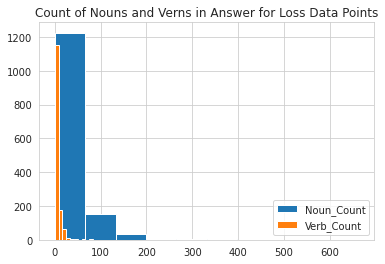

In [184]:
count_noun_title,count_verb_title=pos_tag(df_loss5['answer'])
plt.hist(count_noun_title)
plt.hist(count_verb_title)
plt.title('Count of Nouns and Verns in Answer for Loss Data Points')
plt.legend(["Noun_Count", "Verb_Count"], loc ="lower right") 
plt.show()

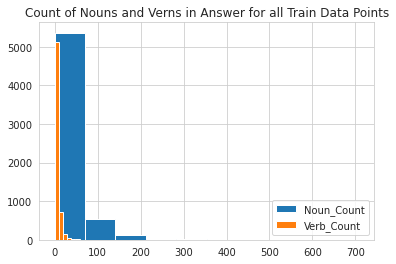

In [185]:
count_noun_title,count_verb_title=pos_tag(train_df['answer'])
plt.hist(count_noun_title)
plt.hist(count_verb_title)
plt.title('Count of Nouns and Verns in Answer for all Train Data Points')
plt.legend(["Noun_Count", "Verb_Count"], loc ="lower right") 
plt.show()

**Observation**

For answer as well we can see that the distribtuion for noun and verbs looks quite similar

#Similarity Test:

One of the other reasons might be because of the variations in the similarity scores for these three. Let us have a look at the same.

In [186]:
from sklearn.metrics.pairwise import cosine_similarity
#similarity for loss data points
quest_ans_similarity_loss=[]
for quest,ans in tqdm(zip(train_title_embedding[loss5_indices],train_question_embedding[loss5_indices])):
  quest=quest.reshape(1,-1)
  ans=ans.reshape(1,-1)
  quest_ans_similarity_loss.append(cosine_similarity(quest,ans))


In [187]:
#similarity for all_train_data points
quest_ans_similarity_train=[]
for quest,ans in tqdm(zip(train_title_embedding,train_question_embedding)):
  quest=quest.reshape(1,-1)
  ans=ans.reshape(1,-1)
  quest_ans_similarity_train.append(cosine_similarity(quest,ans))

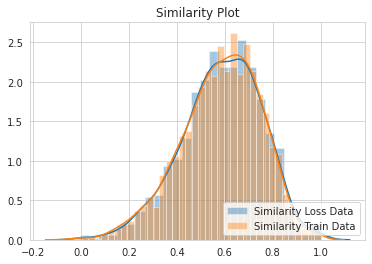

In [188]:
sns.distplot(quest_ans_similarity_loss,kde=True)
sns.distplot(quest_ans_similarity_train,kde=True)
plt.title('Cosine Similarity Plot for Question & Answer')
plt.legend(["Similarity Loss Data", "Similarity Train Data"], loc ="lower right") 
plt.show()

#Observation:

This similarity plot almost overlaps for train and loss data points, hence, this porbably is not the reason for high loss value in our dataset.

In [ ]:
test_output=model.predict(kaggle_input_test)

In [189]:
#saving weights of our model
model.save_weights('model.hdf5')

In [ ]:
print(len(test_output[:,0]))

for i in range(len(target_values)):
    submission[target_values[i]]=test_output[:,i]

In [ ]:
submission.shape

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
os.listdir(path)